#OSP Syllabus Classification

Is a document a document or a syllabus? Using tagged training data, we set out to find out...

In [77]:
from osp.corpus.syllabus import Syllabus
import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
raw_training_df = pd.read_csv('/home/ubuntu/osp-tagging.csv')
print(raw_training_df.columns, raw_training_df.size)

Index(['﻿"id"', 'title', 'text', 'url', 'tags'], dtype='object') 84340


There are many syllabi in the training data that were not tagged. They have an empty value in the tags field that is stored as a float. Remove them, as well as tagged entries with a null in the text field.

In [43]:
training_df = raw_training_df[raw_training_df.tags.apply(
        lambda x: isinstance(x, str)) & ~raw_training_df.text.isnull()]

training_df.reset_index(inplace=True)
print("Raw row count: {}, labeled row count: {}".format(raw_training_df.shape, training_df.shape))

Raw row count: (16868, 5), labeled row count: (772, 6)


The training data is tagged from the Overview project interface. Several different tags were available:

- Course Description
- "Course Description,Not Syllabus"
- Lab Syllabus
- Lesson or Lecture
- "No Citations,Syllabus"
- Not Syllabus
- Reading List
- "Reading List,Syllabus"
- Syllabus
- "Syllabus,Lab Syllabus"
- "Syllabus,No Citations"
- "Syllabus,No Citations,Odd for some reason"
- "Syllabus,Odd for some reason"
- "Syllabus,Odd for some reason,No Citations"

This is a classifier to split syllabi from not, so as long as a document is a syllabus, regardless whether it has citations or not, or whether it is odd, it will be considered a syllabus.

In [44]:
def is_syllabus_tag(tag):
    try:
        return 'syllabus' in tag.lower() and 'not syllabus' not in tag.lower()
    except AttributeError:
        return False

is_syllabus = training_df.tags.apply(is_syllabus_tag)
positive_examples_df = training_df[is_syllabus]
negative_examples_df = training_df[~is_syllabus]

print('Positive examples: {}, negative examples: {}'.format(positive_examples_df.shape, negative_examples_df.shape))

Positive examples: (301, 6), negative examples: (471, 6)


We tokenize the syllabus text in the positive and negative examples, and featurize them for a classifier.

First pass: tf-idf features of text tokens, classified using naive bayes.

In [18]:
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB()),
])

In [29]:
kf = KFold(n=len(training_df), n_folds=5, shuffle=True, random_state=983214)
cv_results = cross_val_score(text_clf, training_df.text.values, is_syllabus.values, cv=kf)
cv_results.mean()

0.86397151235860914

In [31]:
kf = KFold(n=len(training_df), n_folds=5, shuffle=True, random_state=983214)
cv_results = cross_val_score(text_clf, training_df.text.values, is_syllabus.values, cv=kf, scoring='roc_auc')
cv_results.mean()

0.94218518605467172

We get 86.4% mean accuracy and 94.22% mean ROC using out-of-the-box features and the multinomial NB classifier. Let's try tuning the feature set a little.

In [24]:
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2')
}

grid_search = GridSearchCV(text_clf, parameters, n_jobs=-1, verbose=1)
grid_search.fit(training_df.text.values, is_syllabus.values)
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  12 out of  18 | elapsed:  1.3min remaining:   38.8s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.8min finished


Best score: 0.845
Best parameters set:
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)


In this grid search across parameters, having a cutoff that eliminates words with document frequency above 0.5 is more effective than cutoffs at 0.75 and 1. Bigrams also perform better than unigrams. The best score here is lower than the mean score in our stratified run above, so more tests are warranted.

In [ ]:
fprs = []
tprs = []
thresholds = []

kf = KFold(n=len(training_df), n_folds=5, shuffle=True, random_state=983214)
for train, test in kf:
    text_clf.fit(training_df.text[train], is_syllabus[train])
    predictions = text_clf.predict_proba(training_df.text[test])

    fpr, tpr, threshold = roc_curve(is_syllabus[test], predictions[:, 1])
    fprs.append(fpr)
    tprs.append(tpr)
    thresholds.append(threshold)

One question we might ask is: is this good or bad?

The classifier returns a probability between 0 and 1 that a given document is a syllabus. In the ROC curves below, the movement of the line represents the changing false positive and true positive rates for different cutoff values. For example, if the cutoff is 0, then all documents with a probability greater than 0 of being a syllabus (i.e., all documents) will be classified as syllabi, leading us to have perfect precision (TPR=1) but abysmal recall (FPR=1) -- the upper right corner.

This chart shows us that we can choose a threshold somewhere on that line. For example, we can achieve roughly 90% precision with only 20% false positives. How useful this will be in practice will depend on the ratio of syllabi to non-syllabi in the corpus, and our tolerance for errors of either kind.

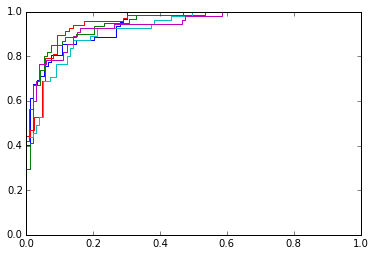

In [70]:
for i in range(len(fprs)):
    plt.plot(fprs[i], tprs[i], lw=1)

plt.show()

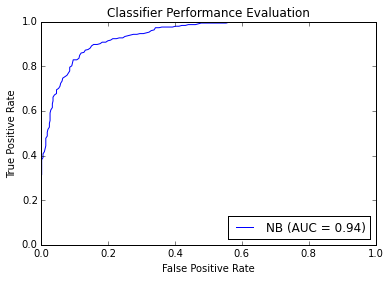

In [85]:
nb_mean_fpr = [np.mean(x) for x in zip(*fprs)]
nb_mean_tpr = [np.mean(x) for x in zip(*tprs)]

nb_auc = auc(nb_mean_fpr, nb_mean_tpr)

plt.plot(nb_mean_fpr, nb_mean_tpr, lw=1, label='NB (AUC = %0.2f)' % nb_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classifier Performance Evaluation')
plt.legend(loc="lower right")
plt.show()